## Computations for Chandrayaan 2 visibility from Dwingeloo

This computation was inpsired by [this tweet](https://twitter.com/df2mz/status/1163040573185544192) from Edgar Kaiser.

In [1]:
from astroquery.jplhorizons import Horizons

In [2]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
from astropy.constants import c as speed_of_light

In [3]:
import matplotlib.pyplot as plt

In [4]:
from matplotlib import dates

In [5]:
import matplotlib

In [6]:
import numpy as np

In [7]:
dwl = EarthLocation(lat="52d48m43.27", lon="6d23m46.21", height="25m")
dwl_jpl = {'lat': dwl.lat.deg, 'lon': dwl.lon.deg, 'elevation': dwl.height.to(u.m).value}

In [8]:
def plot_moonview(az_sat, el_sat, dist_sat, az_luna, el_luna, dist_luna, separation, title=None):
    '''Plot views from the moon
    
    Args:
        az, el, dist: arrays of azimuth / elevation (radians) and distances (km)
    
    Copied and adapted from https://github.com/daniestevez/jupyter_notebooks/blob/master/sat/sat_doppler.py
    '''
    global invisible
    fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))

    MOON_RADIUS = 1737.1
    def angular_radius(r, d):
        return np.arcsin(r/d)
    
    if title is None:
        title = 'Orbit view from receiving groundstation'
    
    angular_radius_luna = angular_radius(MOON_RADIUS, dist_luna)
    max_angular_radius_luna = np.max(angular_radius_luna)
    min_angular_radius_luna = np.min(angular_radius_luna)
    az_diff = (az_sat - az_luna + np.pi) % (2*np.pi) - np.pi
    el_diff = (el_sat - el_luna + np.pi) % (2*np.pi) - np.pi

    # corrections in azimuth apparent size depending on elevation
    azimuth_radius_luna = np.arccos((np.cos(angular_radius_luna)-np.sin(el_luna)**2)/np.cos(el_luna)**2)
    min_azimuth_radius_luna = np.min(azimuth_radius_luna)
    max_azimuth_radius_luna = np.max(azimuth_radius_luna)

    invisible = np.logical_and(separation < angular_radius_luna * u.rad, dist_sat > dist_luna);
    
    ax[0].add_patch(matplotlib.patches.Ellipse((0,0), 2*np.rad2deg(max_azimuth_radius_luna), 2*np.rad2deg(max_angular_radius_luna), color = '0.75'))
    ax[0].add_patch(matplotlib.patches.Ellipse((0,0), 2*np.rad2deg(min_azimuth_radius_luna), 2*np.rad2deg(min_angular_radius_luna), color = 'gray'))
    
    ax[0].plot(np.rad2deg(az_diff[~invisible]), np.rad2deg(el_diff[~invisible]),'.',label='visible')
    ax[0].plot(np.rad2deg(az_diff[invisible]), np.rad2deg(el_diff[invisible]),'.',label='invisible')
    ax[0].annotate('start', xy = (np.rad2deg(az_diff[0]), np.rad2deg(el_diff[0])))
    ax[0].annotate('end', xy = (np.rad2deg(az_diff[-1]), np.rad2deg(el_diff[-1])))
    ax[0].set_aspect(min_azimuth_radius_luna/min_angular_radius_luna)
    ax[0].legend()
    fig.suptitle(title)
    ax[0].set_xlabel('Azimuth offset from Moon (deg)')
    ax[0].set_ylabel('Elevation offset from Moon (deg)')
    ax[1].set_xlabel('Azimuth offset from Moon (deg)')
    ax[1].set_ylabel('Distance offset from Moon (km)')
    ax[1].add_patch(matplotlib.patches.Ellipse((0,0), 2*np.rad2deg(max_azimuth_radius_luna), 2*MOON_RADIUS, color = '0.75'))
    ax[1].add_patch(matplotlib.patches.Ellipse((0,0), 2*np.rad2deg(min_azimuth_radius_luna), 2*MOON_RADIUS, color = 'gray'))
    ax[1].plot(np.rad2deg(az_diff[~invisible]), (dist_sat - dist_luna)[~invisible], '.', label='visible')
    ax[1].plot(np.rad2deg(az_diff[invisible]), (dist_sat - dist_luna)[invisible], '.', label='invisible')
    ax[1].annotate('start', xy = (np.rad2deg(az_diff[0]), dist_sat[0] - dist_luna[0]))
    ax[1].annotate('end', xy = (np.rad2deg(az_diff[-1]), dist_sat[-1] - dist_luna[-1]))
    ax[1].set_aspect(np.rad2deg(min_azimuth_radius_luna)/MOON_RADIUS)
    ax[1].legend()

In [67]:
epochs = Time("2019-09-06T19:00") + np.linspace(0, 1.5, 100, endpoint=False)*u.hour

In [68]:
ephem_chandrayaan = Horizons(id='Chandrayaan-2 (LANDER spacecraft)', location=dwl_jpl,
                             epochs=list(epochs.jd), id_type='majorbody').ephemerides()
# Use location '015' (Utrecht) for vectors since it does not accept Dwingeloo
vectors_chandrayaan = Horizons(id='Chandrayaan-2 (LANDER spacecraft)', location='015',
                               epochs=list(epochs.jd), id_type='majorbody').vectors()

In [69]:
ephem_moon = Horizons(id='301', location=dwl_jpl,
                      epochs=list(epochs.jd), id_type='majorbody').ephemerides()
# Use location '015' (Utrecht) for vectors since it does not accept Dwingeloo
vectors_moon = Horizons(id='301', location='015',
                        epochs=list(epochs.jd), id_type='majorbody').vectors()

In [70]:
moon = SkyCoord(ra=ephem_moon['RA'], dec=ephem_moon['DEC'])
chandrayaan = SkyCoord(ra=ephem_chandrayaan['RA'], dec=ephem_chandrayaan['DEC'])

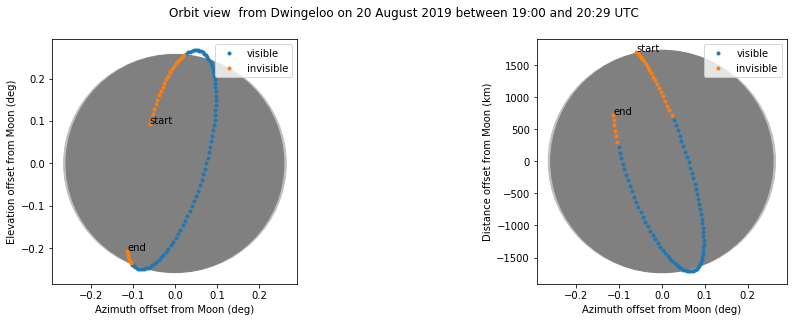

In [71]:
plot_moonview(ephem_chandrayaan['AZ'].to(u.rad).value,
              ephem_chandrayaan['EL'].to(u.rad).value,
              vectors_chandrayaan['range'].to(u.km).value,
              ephem_moon['AZ'].to(u.rad).value,
              ephem_moon['EL'].to(u.rad).value,
              vectors_moon['range'].to(u.km).value,
              moon.separation(chandrayaan),
              title=f"Orbit view  from Dwingeloo on 20 August 2019 between {epochs[0].datetime:%H:%M} and {epochs[-1].datetime:%H:%M} UTC")

In [72]:
epochs[~invisible][0]

<Time object: scale='utc' format='isot' value=2019-09-06T19:18:00.000>

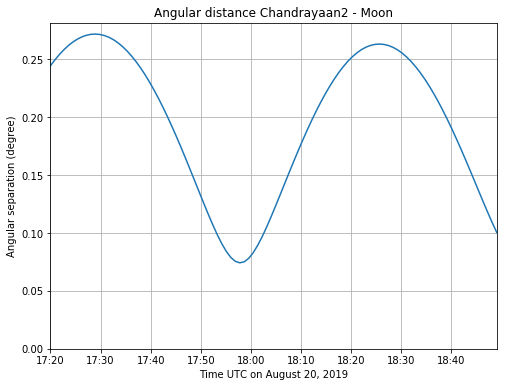

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epochs.datetime, moon.separation(chandrayaan));
ax.set_title("Angular distance Chandrayaan2 - Moon")
ax.grid()
ax.margins(x=0)
ax.set_ylim(0, None)
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_xlabel("Time UTC on August 20, 2019")
ax.set_ylabel("Angular separation (degree)");

In [71]:
def rangerate2doppler(x, freq):
    '''Convert rangerate to doppler
    
    Args:
        x: rangerate (as astropy quantity)
        freq: base frequency (as astropy quantity)
    
    Returns:
        doppler correction

    Copied and adapted from https://github.com/daniestevez/jupyter_notebooks/blob/master/sat/sat_doppler.py
    '''
    return (-x.to(u.m/u.s) * freq / speed_of_light).to(u.Hz)

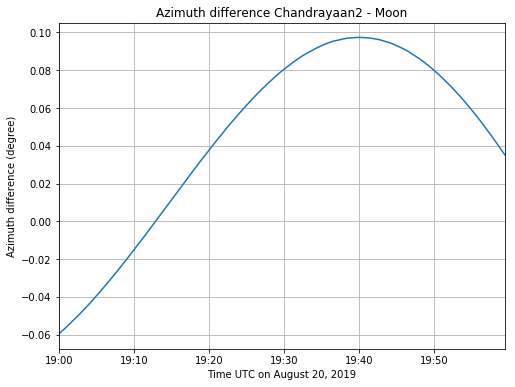

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epochs.datetime, ephem_chandrayaan['AZ'] - ephem_moon['AZ']);
ax.set_title("Azimuth difference Chandrayaan2 - Moon")
ax.grid()
ax.margins(x=0)
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_xlabel("Time UTC on August 20, 2019")
ax.set_ylabel("Azimuth difference (degree)");

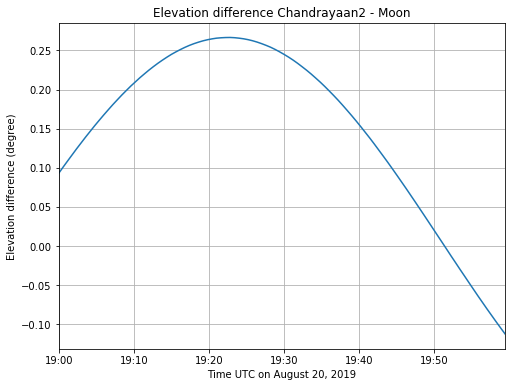

In [54]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epochs.datetime, ephem_chandrayaan['EL'] - ephem_moon['EL']);
ax.set_title("Elevation difference Chandrayaan2 - Moon")
ax.grid()
ax.margins(x=0)
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_xlabel("Time UTC on August 20, 2019")
ax.set_ylabel("Elevation difference (degree)");

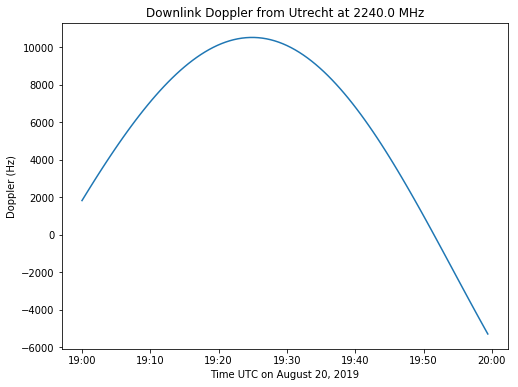

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epochs.datetime, rangerate2doppler(vectors_chandrayaan['range_rate'], 2240*u.MHz));
ax.set_title(f'Downlink Doppler from Utrecht at {2240:.1f} MHz')
ax.set_xlabel("Time UTC on August 20, 2019")
ax.set_ylabel('Doppler (Hz)');
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'));

In [56]:
moon = SkyCoord(ra=ephem_moon['RA'], dec=ephem_moon['DEC'])
chandrayaan = SkyCoord(ra=ephem_chandrayaan['RA'], dec=ephem_chandrayaan['DEC'])

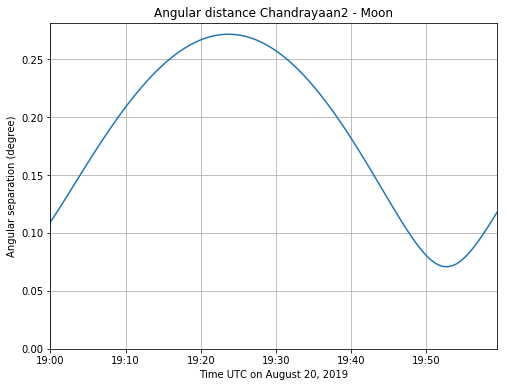

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epochs.datetime, moon.separation(chandrayaan));
ax.set_title("Angular distance Chandrayaan2 - Moon")
ax.grid()
ax.margins(x=0)
ax.set_ylim(0, None)
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_xlabel("Time UTC on August 20, 2019")
ax.set_ylabel("Angular separation (degree)");